# Overlaid Arrow Image Generator Notebook

To support training and inference of the arrow detector, we want to create a pipeline to generate images with a variety of different arrow PNGs randomnly overlaid onto medical images of varying modalities.

In [242]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

In [243]:
def resize_to_width(image_rgb, target_w=1024, interpolation=cv2.INTER_LINEAR):
    """
    Resize an RGB image to the specified width while preserving aspect ratio.

    Parameters:
    - image_rgb: np.ndarray (H,W,3) in RGB
    - target_w: int target width (default: 1024)
    - interpolation: OpenCV interpolation method

    Returns:
    - resized RGB image with width == target_w
    """
    h, w = image_rgb.shape[:2]
    if w == target_w:
        return image_rgb
    target_h = int(round(h * (target_w / w)))
    return cv2.resize(image_rgb, (target_w, target_h), interpolation=interpolation)

In [244]:
def preprocess_arrow(arrow_path, rotation_angle=0, scale_x=None, scale_y=None, scale_master=None, color=None):
    """
    Preprocess arrow PNG by rotating, scaling, and coloring it.

    Parameters:
    -----------
    arrow_image : string
        Filepath of transparent background arrow image located in arrow-pngs folder
    rotation_angle : float
        Rotation angle in degrees (0 = pointing right, 90 = pointing up, -90 = pointing down, 180 = pointing left)
    scale_x : float, optional
        Horizontal scale factor (default: random between 0.2 and 1.0)
    scale_y : float, optional
        Vertical scale factor (default: random between 0.2 and 1.0)
    color : tuple, optional
        RGB color tuple (0-255) to tint the arrow (default: random color)
    
    Returns:
    --------
    arrow_rgb : np.ndarray
        Rotated and scaled arrow image in RGB format
    alpha : np.ndarray
        Alpha channel for the rotated arrow
    tip_local : tuple
        (x, y) coordinates of the arrow tip in the rotated image
    tail_local : tuple
        (x, y) coordinates of the arrow tail in the rotated image
    bbox_local : tuple
        (x_min, y_min, x_max, y_max) of non-zero alpha in rotated image coords
    """
    arrow_image = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)

    # Generate random scale factors if not provided
    if scale_master is None:
        scale_master = random.uniform(0.4, 1.2)
    if scale_x is None:
        scale_x = random.uniform(0.6, 1.4) * scale_master
    if scale_y is None:
        scale_y = random.uniform(0.6, 1.4) * scale_master

    # Generate fully independent RGB if not provided
    if color is None:
        color = tuple(np.random.randint(0, 256, size=3).tolist())

    # Extract BGR and alpha from arrow image
    if arrow_image.shape[2] == 4:
        arrow_bgr = arrow_image[:, :, :3]
        alpha = arrow_image[:, :, 3] / 255.0
    else:
        arrow_bgr = arrow_image
        alpha = np.ones((arrow_image.shape[0], arrow_image.shape[1]))

    # Convert arrow from BGR to RGB
    arrow_rgb = cv2.cvtColor(arrow_bgr, cv2.COLOR_BGR2RGB)

    # Decide on color handling with probabilistic choice
    color_choice = random.random()
    if color_choice < 0.05:
        # 5% chance: invert colors
        mask = alpha > 0
        arrow_rgb[mask] = 255 - arrow_rgb[mask]
    elif color_choice < 0.20:
        # 10% chance: keep original color (do nothing)
        pass
    else:
        # 85% chance: recolor arrow uniformly using the alpha mask so each channel is independent
        mask = alpha > 0
        arrow_rgb[...] = 0
        arrow_rgb[mask] = color

    # Apply random scaling (independently for x and y)
    h, w = arrow_rgb.shape[:2]
    new_w = int(w * scale_x)
    new_h = int(h * scale_y)

    if new_w > 0 and new_h > 0:
        arrow_rgb = cv2.resize(arrow_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        alpha = cv2.resize(alpha, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Original arrow dimensions and tip/tail positions (before rotation)
    # Tip is in the middle of the right side, tail on the left
    original_tip_local = (arrow_rgb.shape[1], arrow_rgb.shape[0] // 2)
    original_tail_local = (0, arrow_rgb.shape[0] // 2)

    # If no rotation needed, return as-is
    if rotation_angle == 0:
        # Compute bbox on current alpha
        ys, xs = np.nonzero(alpha > 0)
        if len(xs) == 0 or len(ys) == 0:
            bbox_local = (0, 0, 0, 0)
        else:
            bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
        return arrow_rgb, alpha, original_tip_local, original_tail_local, bbox_local

    # Get the center of rotation (the tip point)
    h, w = arrow_rgb.shape[:2]
    center = original_tip_local

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Calculate new canvas size to fit the rotated image
    # Get the four corners of the original image
    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [0, h, 1],
        [w, h, 1]
    ]).T

    # Transform corners to find new bounding box
    transformed = rotation_matrix @ corners
    x_coords = transformed[0, :]
    y_coords = transformed[1, :]

    x_min = int(np.floor(x_coords.min()))
    x_max = int(np.ceil(x_coords.max()))
    y_min = int(np.floor(y_coords.min()))
    y_max = int(np.ceil(y_coords.max()))

    new_w = x_max - x_min
    new_h = y_max - y_min

    # Adjust rotation matrix to account for the new canvas position
    rotation_matrix[0, 2] -= x_min
    rotation_matrix[1, 2] -= y_min

    # Rotate the arrow image with the expanded canvas
    arrow_rgb_rotated = cv2.warpAffine(arrow_rgb, rotation_matrix, (new_w, new_h), 
                                        borderMode=cv2.BORDER_CONSTANT, 
                                        borderValue=(0, 0, 0))

    # Rotate the alpha channel
    alpha_rotated = cv2.warpAffine(alpha, rotation_matrix, (new_w, new_h), 
                                     borderMode=cv2.BORDER_CONSTANT, 
                                     borderValue=0)

    # Transform the tail coordinates using the adjusted rotation matrix
    tail_point = np.array([original_tail_local[0], original_tail_local[1], 1]).reshape(3, 1)
    if arrow_path.endswith('arrow7.png'):
        tail_point[0][0] += 80 * scale_x
    elif arrow_path.endswith('arrow16.png'):
        tail_point[0][0] += 150 * scale_x
    elif arrow_path.endswith('arrow13.png'):
        tail_point[1][0] = 0

    tail_rotated = rotation_matrix @ tail_point
    tail_local_rotated = (int(round(tail_rotated[0, 0])), int(round(tail_rotated[1, 0])))

    # Transform the tip coordinates
    tip_point = np.array([original_tip_local[0], original_tip_local[1], 1]).reshape(3, 1)
    if arrow_path.endswith('arrow13.png'):
        tip_point[1][0] += 80 * scale_y

    tip_rotated = rotation_matrix @ tip_point
    tip_local_rotated = (int(round(tip_rotated[0, 0])), int(round(tip_rotated[1, 0])))

    # Compute tight bbox around non-zero alpha
    ys, xs = np.nonzero(alpha_rotated > 0)
    if len(xs) == 0 or len(ys) == 0:
        bbox_local = (0, 0, 0, 0)
    else:
        bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
    
    return arrow_rgb_rotated, alpha_rotated, tip_local_rotated, tail_local_rotated, bbox_local

In [245]:
def arrows_overlap(tip1, tail1, tip2, tail2):
    """
    Check if two arrows overlap based on their tip and tail positions.
    
    Returns True if both X ranges AND Y ranges intersect.
    
    Parameters:
    - tip1, tail1: (x, y) coordinates of first arrow's tip and tail
    - tip2, tail2: (x, y) coordinates of second arrow's tip and tail
    
    Returns:
    - bool: True if arrows overlap (both X and Y ranges intersect)
    """
    # Get X ranges for both arrows
    min_x1, max_x1 = min(tip1[0], tail1[0]), max(tip1[0], tail1[0])
    min_x2, max_x2 = min(tip2[0], tail2[0]), max(tip2[0], tail2[0])
    
    # Get Y ranges for both arrows
    min_y1, max_y1 = min(tip1[1], tail1[1]), max(tip1[1], tail1[1])
    min_y2, max_y2 = min(tip2[1], tail2[1]), max(tip2[1], tail2[1])
    
    # Check if X ranges intersect
    x_overlap = not (max_x1 < min_x2 or max_x2 < min_x1)
    
    # Check if Y ranges intersect
    y_overlap = not (max_y1 < min_y2 or max_y2 < min_y1)
    
    # Both must overlap for arrows to overlap
    return x_overlap and y_overlap


def overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=1, num_arrows=2, tip_margin_ratio=0.05):
    """
    Overlay multiple randomly preprocessed arrows onto a base RGB image.

    Returns:
    - output_rgb: np.ndarray (H,W,3) RGB image with arrows overlaid
    - tips: list of (x, y) tip locations on output image
    - tails: list of (x, y) tail locations on output image
    - bboxes: list of (x_min, y_min, x_max, y_max) for each overlaid arrow
    """
    base_h, base_w = base_image_rgb.shape[:2]
    margin_w = int(tip_margin_ratio * base_w)
    margin_h = int(tip_margin_ratio * base_h)

    # Collect arrow PNGs
    arrow_files = [f for f in os.listdir(arrow_dir) if f.lower().endswith(".png")]
    if not arrow_files:
        raise ValueError(f"No PNG files found in {arrow_dir}")

    def intersect_ranges(current, new_ranges):
        merged = []
        for a_start, a_end in current:
            for b_start, b_end in new_ranges:
                start = max(a_start, b_start)
                end = min(a_end, b_end)
                if start < end:
                    merged.append((start, end))
        return merged

    output = base_image_rgb.copy()
    tips = []
    tails = []
    bboxes = []

    for _ in range(num_arrows):
        max_retries = 3
        arrow_placed = False
        
        for attempt in range(max_retries + 1):
            # Random tip position within margins
            tip_x = random.randint(margin_w, max(margin_w, base_w - margin_w))
            tip_y = random.randint(margin_h, max(margin_h, base_h - margin_h))

            # Angular constraints so tail stays away from nearby edges
            allowed = [(0.0, 360.0)]
            right_edge = tip_x >= 0.8 * base_w
            left_edge = tip_x <= 0.2 * base_w
            top_edge = tip_y <= 0.2 * base_h
            bottom_edge = tip_y >= 0.8 * base_h
            if right_edge:
                allowed = intersect_ranges(allowed, [(0, 90), (270, 360)])
            if left_edge:
                allowed = intersect_ranges(allowed, [(90, 270)])
            if top_edge:
                allowed = intersect_ranges(allowed, [(0, 180)])
            if bottom_edge:
                allowed = intersect_ranges(allowed, [(180, 360)])
            if not allowed:
                allowed = [(0.0, 360.0)]

            spans = [b - a for a, b in allowed]
            total_span = sum(spans)
            pick = random.uniform(0, total_span)
            cumulative = 0.0
            rotation_angle = 0.0
            for (a, b), span in zip(allowed, spans):
                if pick <= cumulative + span:
                    rotation_angle = random.uniform(a, b)
                    break
                cumulative += span

            # Pick random arrow and preprocess with constrained rotation
            arrow_path = os.path.join(arrow_dir, random.choice(arrow_files))
            scale = float(arrow_size) / random.randint(3, 8)
            arrow_rgb, alpha, tip_local, tail_local, bbox_local = preprocess_arrow(arrow_path, rotation_angle, scale_master=scale)

            # Arrow dimensions
            arrow_h, arrow_w = arrow_rgb.shape[:2]

            # Compute tail position in output coordinates
            tail_x = tip_x + (tail_local[0] - tip_local[0])
            tail_y = tip_y + (tail_local[1] - tip_local[1])

            # Check for overlap with existing arrows
            has_overlap = any(arrows_overlap((tip_x, tip_y), (tail_x, tail_y), existing_tip, existing_tail) 
                             for existing_tip, existing_tail in zip(tips, tails))
            
            if has_overlap and attempt < max_retries:
                # Retry with new position
                continue
            elif has_overlap and attempt == max_retries:
                # Skip this arrow after max retries
                break
            
            # No overlap, proceed with placement
            # Placement (top-left of arrow on output) so tip aligns
            arrow_x = tip_x - tip_local[0]
            arrow_y = tip_y - tip_local[1]

            # Overlap region
            y_start = max(0, arrow_y)
            y_end = min(base_h, arrow_y + arrow_h)
            x_start = max(0, arrow_x)
            x_end = min(base_w, arrow_x + arrow_w)

            # Corresponding region in arrow image
            arrow_y_start = y_start - arrow_y
            arrow_y_end = y_end - arrow_y
            arrow_x_start = x_start - arrow_x
            arrow_x_end = x_end - arrow_x

            # Blend
            if (y_end > y_start) and (x_end > x_start):
                alpha_region = alpha[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end]
                for c in range(3):
                    output[y_start:y_end, x_start:x_end, c] = (
                        output[y_start:y_end, x_start:x_end, c] * (1 - alpha_region) +
                        arrow_rgb[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end, c] * alpha_region
                    )

            # Compute bbox in output coordinates by shifting local bbox
            bx0, by0, bx1, by1 = bbox_local
            bbox_out = (
                arrow_x + bx0,
                arrow_y + by0,
                arrow_x + bx1,
                arrow_y + by1
            )

            tips.append((tip_x, tip_y))
            tails.append((tail_x, tail_y))
            bboxes.append(bbox_out)
            arrow_placed = True
            break

    return output, tips, tails, bboxes

## Demonstration on an Example Image

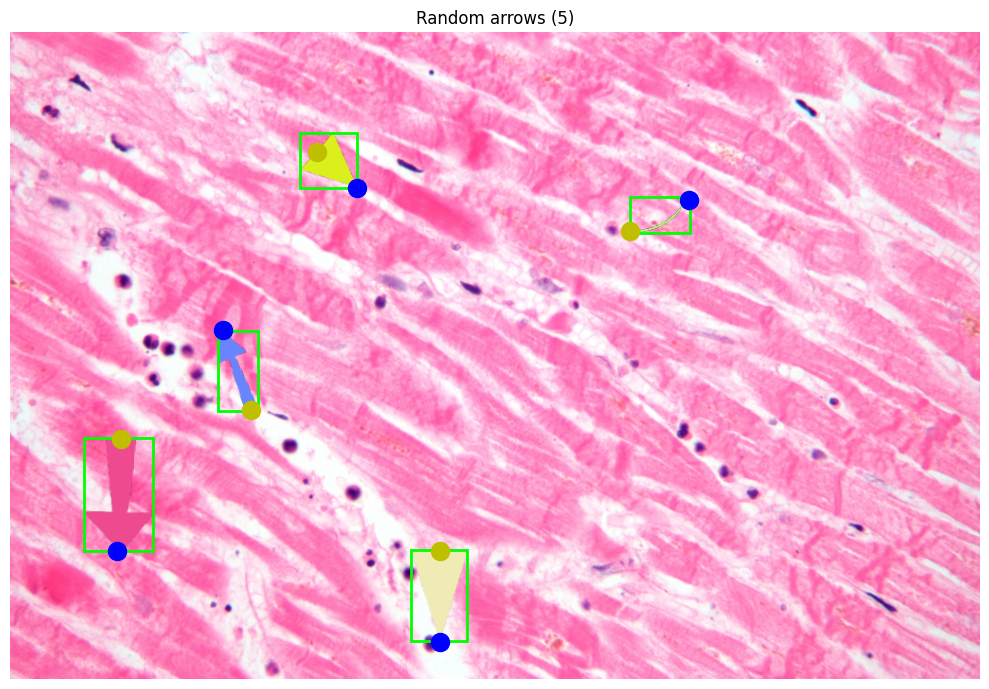

In [246]:
# Load base medical image
base_image_path = "medical-images/image1.jpg"
base_image = cv2.imread(base_image_path)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

# Resize to width 1024 while preserving aspect ratio
base_image_rgb = resize_to_width(base_image_rgb, target_w=1024)

# Overlay multiple random arrows using the new helper function
arrow_dir = "arrow-pngs"
output_rgb, tips, tails, bboxes = overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=0.8, num_arrows=5)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)
# Mark each tip and tail location
for i, (tip, tail) in enumerate(zip(tips, tails), start=1):
    plt.plot(tip[0], tip[1], 'bo', markersize=12, markeredgewidth=2, label=f'Tip {i}')
    plt.plot(tail[0], tail[1], 'yo', markersize=12, markeredgewidth=2, label=f'Tail {i}')

# Draw bounding boxes
for i, bbox in enumerate(bboxes, start=1):
    bx0, by0, bx1, by1 = bbox
    width = bx1 - bx0
    height = by1 - by0
    rect = patches.Rectangle((bx0, by0), width, height, linewidth=2, edgecolor='lime', facecolor='none', label=f'BBox {i}')
    plt.gca().add_patch(rect)

plt.title(f"Random arrows ({len(bboxes)})")
#plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

## Dataset Generation

In [247]:
# Batch-generate overlaid arrow images for the dataset with train/valid/test splits

medical_dir = "medical-images"
arrow_dir = "arrow-pngs"
output_base_dir = "synthetic-medical-arrows"

# Create YOLO-style folder structure
train_img_dir = os.path.join(output_base_dir, "train", "images")
train_label_dir = os.path.join(output_base_dir, "train", "labels")
valid_img_dir = os.path.join(output_base_dir, "valid", "images")
valid_label_dir = os.path.join(output_base_dir, "valid", "labels")
test_img_dir = os.path.join(output_base_dir, "test", "images")
test_label_dir = os.path.join(output_base_dir, "test", "labels")

for dir_path in [train_img_dir, train_label_dir, valid_img_dir, valid_label_dir, test_img_dir, test_label_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Collect medical images (common extensions)
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
medical_files = [f for f in os.listdir(medical_dir) if os.path.splitext(f)[1].lower() in valid_exts]
if not medical_files:
    raise ValueError(f"No images found in {medical_dir} with extensions {sorted(valid_exts)}")

# Double the list for data augmentation (each image will be used twice with different random arrows)
medical_files = medical_files * 2

# Randomize the order of files
random.shuffle(medical_files)

# Calculate split indices (80/10/10)
total_files = len(medical_files)
train_end = int(0.8 * total_files)
valid_end = int(0.9 * total_files)

train_files = medical_files[:train_end]
valid_files = medical_files[train_end:valid_end]
test_files = medical_files[valid_end:]

print(f"Found {len(set(medical_files))} unique medical images.")
print(f"Doubled to {len(medical_files)} total for 2x augmentation.")
print(f"Split: Train={len(train_files)}, Valid={len(valid_files)}, Test={len(test_files)}")
print(f"Writing to '{output_base_dir}' with YOLO folder structure.")

# Process each split
for split_name, split_files, img_dir, label_dir in [
    ("train", train_files, train_img_dir, train_label_dir),
    ("valid", valid_files, valid_img_dir, valid_label_dir),
    ("test", test_files, test_img_dir, test_label_dir)
]:
    print(f"\nProcessing {split_name} split ({len(split_files)} images)...")
    
    for idx, img_name in enumerate(split_files, start=1):
        try:
            base_image_path = os.path.join(medical_dir, img_name)
            base_image = cv2.imread(base_image_path)
            if base_image is None:
                print(f"[Skip] Could not read: {img_name}")
                continue
            base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

            # Resize to width 1024 while preserving aspect ratio
            base_image_rgb = resize_to_width(base_image_rgb, target_w=1024)

            base_h, base_w = base_image_rgb.shape[:2]

            # Generate number of arrows using Gaussian distribution (mean=3, std=2, clipped to [0,8])
            num_arrows = int(np.clip(np.round(np.random.normal(3, 2)), 0, 8))
            
            # Use helper to overlay multiple random arrows on resized image
            output_rgb, tips, tails, bboxes = overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=1, num_arrows=num_arrows)

            # Save output image with numeric index
            img_ext = os.path.splitext(img_name)[1]
            out_path = os.path.join(img_dir, f"{idx}{img_ext}")
            output_bgr = cv2.cvtColor(output_rgb, cv2.COLOR_RGB2BGR)
            ok = cv2.imwrite(out_path, output_bgr)
            if not ok:
                print(f"[Warn] Failed to write: {out_path}")
                continue

            # Write YOLO pose-format labels (one line per arrow: class 0, bbox + tip/tail keypoints)
            label_path = os.path.join(label_dir, f"{idx}.txt")
            with open(label_path, "w", encoding="utf-8") as f:
                for tip, tail, bbox in zip(tips, tails, bboxes):
                    bx0, by0, bx1, by1 = bbox
                    cx = (bx0 + bx1) / 2.0 / base_w
                    cy = (by0 + by1) / 2.0 / base_h
                    bw = (bx1 - bx0) / base_w
                    bh = (by1 - by0) / base_h
                    tip_xn, tip_yn = tip[0] / base_w, tip[1] / base_h
                    tail_xn, tail_yn = tail[0] / base_w, tail[1] / base_h
                    label_line = f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f} {tip_xn:.6f} {tip_yn:.6f} 2 {tail_xn:.6f} {tail_yn:.6f} 2"
                    f.write(label_line + "\n")

            if idx % 10 == 0 or idx == len(split_files):
                print(f"  {split_name}: {idx}/{len(split_files)} | arrows={len(bboxes)}")

        except Exception as e:
            print(f"[Error] Skipping {img_name} due to error: {e}")
            continue

print(f"\n{'='*60}")
print(f"Dataset generation complete!")
print(f"Structure:")
print(f"  {output_base_dir}/train/images & labels ({len(train_files)} images)")
print(f"  {output_base_dir}/valid/images & labels ({len(valid_files)} images)")
print(f"  {output_base_dir}/test/images & labels ({len(test_files)} images)")
print(f"{'='*60}")

Found 365 unique medical images.
Doubled to 730 total for 2x augmentation.
Split: Train=584, Valid=73, Test=73
Writing to 'synthetic-medical-arrows' with YOLO folder structure.

Processing train split (584 images)...
  train: 10/584 | arrows=1
  train: 20/584 | arrows=3
  train: 30/584 | arrows=2
  train: 40/584 | arrows=5
  train: 50/584 | arrows=0
  train: 60/584 | arrows=6
  train: 70/584 | arrows=4
  train: 80/584 | arrows=5
  train: 90/584 | arrows=1
  train: 100/584 | arrows=6
  train: 110/584 | arrows=3
  train: 120/584 | arrows=1
  train: 130/584 | arrows=2
[Error] Skipping 802.jpg due to error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:79: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'validateInputImageSize'

  train: 140/584 | arrows=3
  train: 150/584 | arrows=0
  train: 160/584 | arrows=2
  train: 170/584 | arrows=5
  train: 180/584 | arrows=4
  train: 190/584

### Visualize Generated Labels

Verify that the YOLO pose format annotations are correct by visualizing the first generated image with its labels.

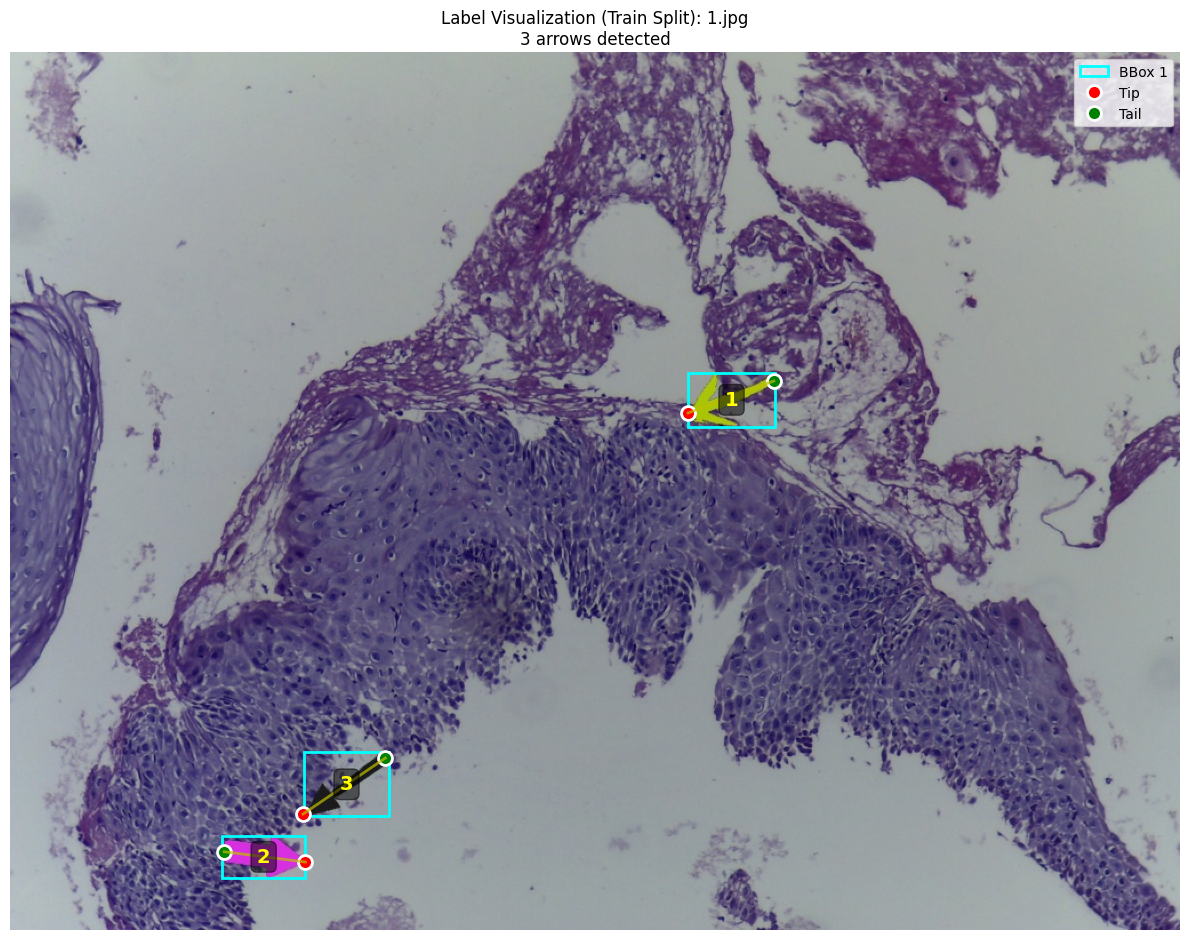


Image: train/images/1.jpg (1024x768)
Label file: train/labels/1.txt

Arrow 1:
  Class: 0
  BBox (normalized): cx=0.6162, cy=0.3952, w=0.0742, h=0.0612
  Tip (normalized): x=0.5791, y=0.4102 | visibility: 2
  Tail (normalized): x=0.6523, y=0.3737 | visibility: 2

Arrow 2:
  Class: 0
  BBox (normalized): cx=0.2163, cy=0.9160, w=0.0713, h=0.0482
  Tip (normalized): x=0.2520, y=0.9219 | visibility: 2
  Tail (normalized): x=0.1826, y=0.9102 | visibility: 2

Arrow 3:
  Class: 0
  BBox (normalized): cx=0.2871, cy=0.8333, w=0.0723, h=0.0729
  Tip (normalized): x=0.2500, y=0.8672 | visibility: 2
  Tail (normalized): x=0.3203, y=0.8034 | visibility: 2


In [250]:
# Load the first generated image and its label from the train split
dataset_base_dir = "synthetic-medical-arrows"
train_img_dir = os.path.join(dataset_base_dir, "train", "images")
train_label_dir = os.path.join(dataset_base_dir, "train", "labels")

# Find first image (could be any extension)
img_files = sorted([f for f in os.listdir(train_img_dir) if f.startswith("1.")])
if not img_files:
    print("No generated images found! Run the dataset generation cell first.")
else:
    first_img = img_files[0]
    img_path = os.path.join(train_img_dir, first_img)
    label_path = os.path.join(train_label_dir, "1.txt")
    
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    # Parse label file
    arrows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            if len(parts) == 11:  # class, cx, cy, w, h, tip_x, tip_y, tip_vis, tail_x, tail_y, tail_vis
                class_id, cx, cy, bw, bh, tip_x, tip_y, tip_vis, tail_x, tail_y, tail_vis = parts
                arrows.append({
                    'class': int(class_id),
                    'bbox': (cx, cy, bw, bh),
                    'tip': (tip_x, tip_y),
                    'tip_visibility': int(tip_vis),
                    'tail': (tail_x, tail_y),
                    'tail_visibility': int(tail_vis)
                })
            elif len(parts) == 9:  # Legacy format without visibility (backward compatibility)
                class_id, cx, cy, bw, bh, tip_x, tip_y, tail_x, tail_y = parts
                arrows.append({
                    'class': int(class_id),
                    'bbox': (cx, cy, bw, bh),
                    'tip': (tip_x, tip_y),
                    'tip_visibility': 2,
                    'tail': (tail_x, tail_y),
                    'tail_visibility': 2
                })
    
    # Visualize
    plt.figure(figsize=(12, 10))
    plt.imshow(img_rgb)
    
    for i, arrow in enumerate(arrows, start=1):
        # Convert normalized coords back to pixel coords
        cx_norm, cy_norm, bw_norm, bh_norm = arrow['bbox']
        cx_px = cx_norm * w
        cy_px = cy_norm * h
        bw_px = bw_norm * w
        bh_px = bh_norm * h
        
        # Bbox corners
        x1 = cx_px - bw_px / 2
        y1 = cy_px - bh_px / 2
        
        # Draw bbox
        rect = patches.Rectangle((x1, y1), bw_px, bh_px, 
                                linewidth=2, edgecolor='cyan', facecolor='none',
                                label=f'BBox {i}' if i == 1 else '')
        plt.gca().add_patch(rect)
        
        # Draw keypoints
        tip_x_px = arrow['tip'][0] * w
        tip_y_px = arrow['tip'][1] * h
        tail_x_px = arrow['tail'][0] * w
        tail_y_px = arrow['tail'][1] * h
        
        plt.plot(tip_x_px, tip_y_px, 'ro', markersize=10, markeredgewidth=2, 
                markeredgecolor='white', label=f'Tip' if i == 1 else '')
        plt.plot(tail_x_px, tail_y_px, 'go', markersize=10, markeredgewidth=2,
                markeredgecolor='white', label=f'Tail' if i == 1 else '')
        
        # Draw arrow line
        plt.plot([tail_x_px, tip_x_px], [tail_y_px, tip_y_px], 
                'y-', linewidth=2, alpha=0.7)
        
        # Add text annotation
        plt.text(cx_px, cy_px, f'{i}', color='yellow', fontsize=14, 
                fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    plt.title(f"Label Visualization (Train Split): {first_img}\n{len(arrows)} arrows detected")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print label details for verification
    print(f"\n{'='*60}")
    print(f"Image: train/images/{first_img} ({w}x{h})")
    print(f"Label file: train/labels/1.txt")
    print(f"{'='*60}")
    for i, arrow in enumerate(arrows, start=1):
        print(f"\nArrow {i}:")
        print(f"  Class: {arrow['class']}")
        print(f"  BBox (normalized): cx={arrow['bbox'][0]:.4f}, cy={arrow['bbox'][1]:.4f}, w={arrow['bbox'][2]:.4f}, h={arrow['bbox'][3]:.4f}")
        print(f"  Tip (normalized): x={arrow['tip'][0]:.4f}, y={arrow['tip'][1]:.4f} | visibility: {arrow['tip_visibility']}")
        print(f"  Tail (normalized): x={arrow['tail'][0]:.4f}, y={arrow['tail'][1]:.4f} | visibility: {arrow['tail_visibility']}")